# Setups

In [20]:
import numpy as np
from matplotlib import pyplot as plt

def plot_raster(spike):
    neuronId, timeStamp = np.where(spike==1)
    plt.plot(timeStamp, neuronId, 'k|')
    plt.xlabel('Time')
    plt.ylabel('Neuron')
    plt.xlim(0,2500)
    plt.ylim(-0.5, 9.5)

def plot_initial_traces():
    plt.figure(figsize = (5,5))
    plt.subplot(3,1,1)
    plot_raster(inputs_instructive)
    plt.title('inputs_instructive')

    plt.subplot(3,1,2)
    plt.plot(dopamine)
    plt.title('Dopamine')
    plt.xlim(0,2500)

    plt.subplot(3,1,3)
    plot_raster(spike_inputs)
    plt.title('spike_inputs')
    plt.tight_layout()

def plot_output_neurons():
    plt.figure(figsize = (5,5))
    plt.subplot(3,1,1)
    plt.title('Voltage of output neurons')
    plt.imshow(volt_outputs, aspect='auto', interpolation='none')
    plt.subplot(3,1,2)
    plt.plot(volt_outputs[3,:])
    plt.plot(volt_outputs[6,:])
    plt.title('Voltage of neuron 3 and 6')
    plt.xlim(0,2500)
    plt.subplot(3,1,3)
    plt.title('Spiking of output neurons')
    plot_raster(spike_outputs)
    plt.tight_layout()

def plot_readout_neurons():
    plt.figure(figsize = (5,5))
    plt.subplot(3,1,1)
    plt.title('Voltage of readout neurons')
    plt.imshow(volt_readout, aspect='auto', interpolation='none')
    plt.subplot(3,1,2)
    plt.plot(volt_readout[3,:])
    plt.plot(volt_readout[6,:])
    plt.title('Voltage of neuron 3 and 6')
    plt.xlim(0,2500)
    plt.subplot(3,1,3)
    plt.title('Spiking of readout neurons')
    plot_raster(spike_readout)
    plt.tight_layout()

Set up the simulation params

In [21]:


params = {
    'N_inp': 10, # Number of input neurons
    'N_out': 10, # Number of output neurons
    'N_instructive': 10, # Number of instructive neurons
    'N_supervised': 10, # Number of supervised neurons
    'N_readout': 10, # Number of readouts

    'T': 2500, # Total duration of the simulation [ms]
    'Tinp': 1000, # The total duration where inputs are provided
    'Tinphalf': 500, # 
    'Tdop': 2500 - 1000, # T-Tinp, time of start of dopamine release

    'inp_rate': 0.02, #
    'instructive_rate': 0.5,
    'supervised_rate': 0.06,
    'threshold': 0,
    'threshold_caseC': 0.25,
    'instrinc': 0.06,

    'tau_mem': 10, # Membrane time constant
    'alpha_LTP': 0.0002, # Alpha_LTP, in the original script it was alpha_w
    "alpha_w_standRL": 0.0002 / 50,  # alpha_w / 50
    "alpha_LTD": 0.0002 / 500,  # alpha_w / 500
    "tau_burst": 5, # Burst time constant
    "burst_threshold": 1.1,
    "tau_stdp": 10, # STDP time constant
    "tau_eligibility": 10 * 60 * 1000,  # 10 min in milliseconds
    "tau_inb_trace": 50,
    "Total_trail": 100,
}

params['threshold'] = 0.4*np.ones(params['N_out'])

In [44]:
weight = np.ones((params['N_inp'], params['N_out']))/params['N_inp']
weight_p = weight*0
weight_m = weight*0
weight_instructive = np.eye(params['N_instructive'], params['N_out'])/params['N_instructive']
weight_supervised = np.eye(params['N_instructive'], params['N_out'])
weight_readout = np.eye(params['N_instructive'], params['N_out'])/params['N_supervised']

weight_inhibiton = np.ones((params['N_inp'],params['N_out']))/params['N_inp']
# Set the diagonal component to zero such that the neurons won't inhibit itself
idx = np.eye(weight_inhibiton.shape[0]).astype(bool)
weight_inhibiton[idx] = 0 

# Initializing space for params
volt_outputs = np.zeros((params['N_out'], params['T']))
spike_outputs = np.zeros((params['N_out'], params['T']))
volt_readout = np.zeros((params['N_out'], params['T']))
spike_readout = np.zeros((params['N_out'], params['T']))
inputs_readout_trace = np.zeros((params['N_out'], params['T']))
burst = np.zeros((params['N_out'], params['T']))
x_pre = np.zeros(params['N_inp'])
x_post = np.zeros(params['N_out'])
prepost = np.zeros((params['N_inp'],params['N_out']))
eligibility = np.zeros((params['N_inp'],params['N_out']))
dopamine = np.zeros(params['T'])
inputs_instructive = np.zeros((params['N_instructive'], params['T']))
inputs_supervised = np.zeros((params['N_supervised'], params['T']))
spike_inputs = np.zeros((params['N_inp'], params['T']))
intrinsic_current = np.zeros((params['N_inp'], params['T']))

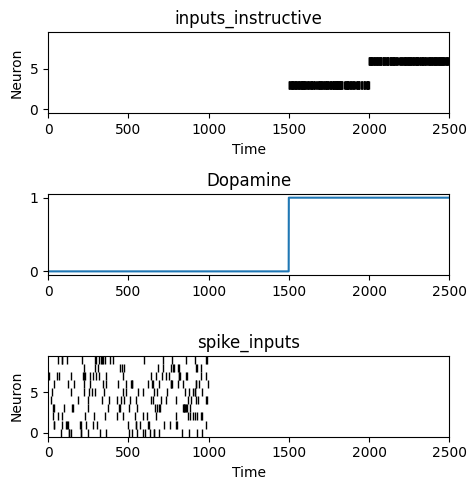

In [45]:
inputs_instructive[3, params['Tdop']:params['T']-params['Tinphalf']] = np.random.random(params['Tinphalf'])<params['instructive_rate']
inputs_instructive[6, params['Tdop']+params['Tinphalf']:params['T']] = np.random.random(params['Tinphalf'])<params['instructive_rate']
dopamine[params['Tdop']:params['T']] = np.ones(params['T']- params['Tdop'])
spike_inputs[:,0:params['Tinp']] = np.random.random((params['N_inp'],params['Tinp'])) < params['inp_rate']

plot_initial_traces()

In [ ]:
def decay(volt, tau):
    return (1-1/tau)*volt

def fire_and_reset(volt, spike, threshold):
    idx_spikes = volt[:,t] > threshold
    spike[idx_spikes, t] = 1
    volt[idx_spikes, t+1] = 0
    return spike, volt

def update_volt_outputs():
    # Update the voltage of the output neurons in t+1 time step
    voltDecay = decay(volt_outputs[:,t], params['tau_mem'])
    voltFromInput = weight.T @ spike_inputs[:,t]
    voltInstructive = weight_instructive.T @ inputs_instructive[:,t]
    voltRead = weight_supervised.T @ spike_readout[:,t-1] # Why is this t-1?
    voltIntrinsic = intrinsic_current[:,t] # Intrinsic current is set to 0 which is a bit different to the written method
    return voltDecay + voltFromInput + voltInstructive + voltRead + voltIntrinsic

def update_volt_readout():
    voltDecay = decay(volt_readout[:,t], params['tau_mem'])
    voltFromOutput = weight_readout.T @ spike_outputs[:,t]
    voltSupervised = inputs_supervised[:,t]
    voltInhib = weight_inhibiton.T @ inputs_readout_trace[:,t-1]
    return voltDecay + voltFromOutput + voltSupervised - voltInhib


for t in range(1,params['T']-1):
    # Update the voltage of the output neurons and readout neurons
    volt_outputs[:,t+1] = update_volt_outputs()
    volt_readout[:,t+1] = update_volt_readout()

    # Determine the spikes in the output neurons and readout neurons
    spike_outputs, volt_outputs = fire_and_reset(volt_outputs, spike_outputs, params['threshold'])
    spike_readout, volt_readout = fire_and_reset(volt_readout, spike_readout, params['threshold'])

    inputs_readout_trace[:,t] = decay(inputs_readout_trace[:,t], params['tau_inb_trace']) + spike_readout[:,t]

    burst[:,t+1] = decay(burst[:,t], params['tau_burst']) + spike_outputs[:,t]
    # Calculate the eligibility trace
    x_pre = x_pre * (1-1/params['tau_stdp']) + spike_inputs[:,t]
    x_post = x_post * (1-1/params['tau_stdp']) + spike_outputs[:,t]
    prepost = x_pre * x_post[np.newaxis].T
    eligibility = eligibility * (1-1/params['tau_eligibility']) + prepost

    # Update the weights (w(inp->o) = alpha_LTP*d*e*b)
    d = dopamine[t]
    e = eligibility
    b = np.ones((params['N_inp'],1)) @ (burst[:,t]>params['burst_threshold'])[np.newaxis]
    weight_p = weight_p + params['alpha_LTP']*d*e @ b
    weight_m = weight_m - params['alpha_LTD']*eligibility

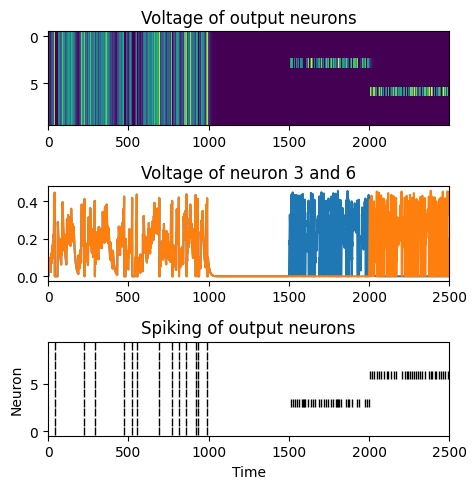

In [47]:
plot_output_neurons()

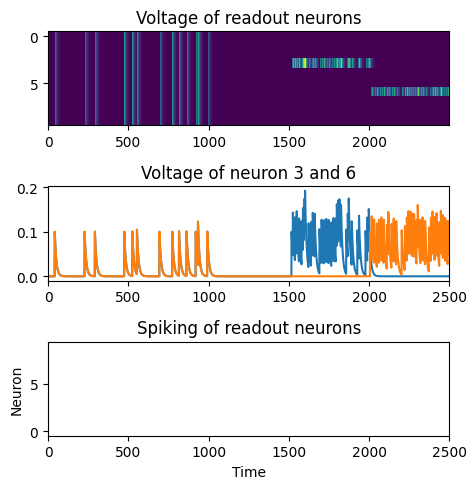

In [48]:
plot_readout_neurons()

In [9]:


plot_raster(spike)


NameError: name 'spike' is not defined